<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/PJH/New_Graphcodebert_%ED%95%98%EC%9D%B4%ED%8D%BC%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0%EC%9E%90%EB%8F%99%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install shap
!pip install datasets
!pip install optuna
!pip install imbalanced-learn

In [100]:
import pandas as pd
import numpy as np
import torch
import optuna
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import re
from transformers import DataCollatorWithPadding
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [109]:
# 데이터 로드 및 전처리
df = pd.read_csv('/content/drive/MyDrive/data/MSR+julite+Div_final_train(2500cut_plus_alpha).csv')

In [110]:
columns_to_drop = ['CWE ID', 'vul', 'lang']
df = df.drop(columns=columns_to_drop)

print(df.columns)

Index(['code', 'labels'], dtype='object')


In [111]:
df = df.sort_values(by=['labels'])
df.reset_index(drop=True, inplace=True)

In [112]:
# 전처리 함수 정의
def preprocess(df, file_name):
    # 멀티 라인 주석 제거
    df['code'] = df['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    # 싱글 라인 주석 제거
    df['code'] = df['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    # angle brackets를 사용하는 include 제거
    df['code'] = df['code'].replace(re.compile(r'#include <.*?>\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include ".*?"\n'), "", regex=True)
    # 매크로 정의 제거
    df['code'] = df['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    # 전처리 지시문 제거
    df['code'] = df['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#endif'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#indef'),"", regex=True)
    # 탭과 여러 공백을 하나의 공백으로
    df['code'] = df['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    # 여러 줄바꿈을 하나로
    df['code'] = df['code'].replace(re.compile(r'\n\s*\n'), "\n", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n'), " ", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return\s*.*?;'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return;'), "", regex=True)
    # void func로 변경
    df['code'] = df['code'].replace(re.compile(r'\b([a-zA-Z_]\w*)\s+([a-zA-Z_]\w*)\s*\(.*?\)\s*{'), r"void func() {", regex=True)
    # 중복된 code 내용 제거
    df = df.drop_duplicates(subset=['code'])

    # 데이터프레임을 CSV 파일로 저장
    df.to_csv(file_name, index=False)
    return df  # 수정된 데이터프레임 반환

In [113]:
# 데이터셋을 Pandas DataFrame으로 변환
df = preprocess(df, "preprocess.csv")

In [114]:
# 오버샘플링 적용
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df.drop(columns=['labels']), df['labels'])

In [115]:
# 오버샘플링 후 클래스 분포 확인
print(f"Resampled dataset shape: {Counter(y_res)}")

Resampled dataset shape: Counter({0: 2035, 1: 2035, 2: 2035, 3: 2035, 4: 2035, 5: 2035, 6: 2035, 7: 2035, 8: 2035})


In [117]:
# 오버샘플링된 데이터를 다시 Dataset 객체로 변환
resampled_df = pd.concat([X_res, y_res], axis=1)
resampled_dataset = Dataset.from_pandas(resampled_df)

In [118]:
# 토큰화 함수 정의
tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
MAX_LEN = 512

def tokenized(examples):
    return tokenizer(examples['code'], pad_to_max_length=True, max_length=MAX_LEN, truncation=True, return_token_type_ids=True)

In [119]:
# 데이터셋 로드 및 전처리
dataset = load_dataset("csv", data_files="preprocess.csv")['train']
encoded_dataset = resampled_dataset.map(tokenized, remove_columns=['code'], batched=True)

encoded_dataset = encoded_dataset.train_test_split(0.3, seed=11)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/18315 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [120]:
# 레이블 값 출력 확인
print(encoded_dataset['train']['labels'])
print(encoded_dataset['test']['labels'])

[3, 7, 7, 5, 5, 5, 7, 4, 3, 6, 8, 7, 7, 6, 1, 0, 0, 5, 1, 1, 3, 7, 4, 2, 6, 8, 4, 8, 2, 0, 8, 6, 3, 3, 5, 1, 4, 5, 3, 1, 7, 2, 7, 0, 1, 4, 6, 8, 5, 4, 8, 6, 1, 4, 7, 3, 7, 7, 5, 1, 1, 5, 3, 2, 1, 1, 2, 3, 1, 7, 6, 8, 3, 2, 4, 8, 1, 6, 0, 5, 1, 8, 2, 5, 0, 2, 4, 3, 1, 8, 8, 1, 2, 6, 0, 8, 8, 2, 1, 6, 0, 4, 3, 5, 7, 2, 2, 2, 2, 3, 1, 5, 4, 0, 1, 1, 3, 5, 7, 5, 3, 1, 5, 5, 1, 5, 7, 0, 4, 8, 0, 1, 8, 4, 6, 7, 0, 2, 3, 5, 1, 7, 8, 2, 6, 5, 7, 1, 5, 4, 8, 6, 0, 7, 2, 7, 1, 7, 3, 6, 4, 1, 6, 7, 0, 7, 0, 7, 5, 5, 6, 4, 2, 8, 3, 0, 3, 5, 7, 5, 0, 6, 4, 4, 6, 6, 6, 2, 5, 7, 0, 4, 1, 4, 2, 5, 3, 8, 1, 0, 1, 2, 4, 0, 6, 5, 8, 7, 6, 8, 1, 4, 7, 5, 8, 0, 3, 0, 8, 2, 7, 2, 6, 7, 0, 6, 5, 8, 7, 8, 7, 5, 7, 2, 1, 6, 7, 2, 5, 5, 2, 0, 0, 0, 2, 1, 2, 1, 6, 5, 7, 2, 5, 7, 3, 2, 4, 3, 7, 8, 7, 6, 6, 6, 6, 6, 8, 0, 0, 4, 5, 7, 5, 1, 5, 7, 0, 3, 8, 0, 2, 6, 1, 8, 3, 2, 1, 8, 0, 7, 7, 4, 0, 5, 4, 4, 7, 7, 8, 3, 3, 8, 0, 3, 7, 4, 6, 5, 3, 0, 0, 5, 0, 0, 7, 3, 1, 0, 7, 8, 5, 2, 7, 6, 2, 0, 4, 0, 7, 4, 6, 7, 6, 

In [121]:
# 모델 초기화
model = AutoModelForSequenceClassification.from_pretrained("microsoft/graphcodebert-base", num_labels=9)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [122]:
# 옵티마이저 및 스케줄러 설정
learning_rate = 2e-5
def create_optimizer_and_scheduler(self, num_training_steps):
    self.optimizer = torch.optim.AdamW(
        self.model.parameters(),
        lr=learning_rate,
        betas=(0.9, 0.99),
        eps=1e-8,
        weight_decay=0.1
    )
    self.lr_scheduler = get_cosine_schedule_with_warmup(
        self.optimizer,
        num_warmup_steps=5,
        num_training_steps=num_training_steps
    )
    return self.optimizer, self.lr_scheduler

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [123]:
# 메트릭 계산 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    f1_per_class = f1_score(labels, predictions, average=None)
    f1_weighted = f1_score(labels, predictions, average='weighted')
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    recall_weighted = recall_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    metrics = {
        'accuracy': accuracy,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    }

    for i, f1 in enumerate(f1_per_class):
        metrics[f'f1_class_{i}'] = f1

    return metrics

In [124]:
# 사용자 정의 콜백 클래스 정의
class CustomTrainerCallback(TrainerCallback):
    def __init__(self, trainer, eval_dataset, early_stopping_patience=5):
        self.trainer = trainer
        self.eval_dataset = eval_dataset
        self.early_stopping_patience = early_stopping_patience
        self.best_loss = float('inf')
        self.patience_counter = 0
        self.incorrect_samples = []

    def on_evaluate(self, args, state, control, **kwargs):
        eval_loss = kwargs.get('metrics', {}).get('eval_loss')

        if eval_loss is not None:
            if eval_loss < self.best_loss:
                self.best_loss = eval_loss
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.early_stopping_patience:
                print(f"No improvement in {self.early_stopping_patience} evaluation steps. Stopping training early.")
                control.should_training_stop = True

        eval_dataloader = self.trainer.get_eval_dataloader(self.eval_dataset)
        self.trainer.model.eval()
        for batch in eval_dataloader:
            batch = {k: v.to(self.trainer.args.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = self.trainer.model(**batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                labels = batch['labels']
                incorrect_mask = predictions != labels

            if incorrect_mask.any():
                incorrect_samples = {k: v[incorrect_mask].cpu().numpy() for k, v in batch.items()}
                self.incorrect_samples.append(incorrect_samples)

        print("Collected incorrect predictions for further analysis.")

In [125]:
# 하이퍼파라미터 공간 정의 함수
def hp_space(trial):
    return {
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True),
        'per_device_train_batch_size': trial.suggest_categorical('per_device_train_batch_size', [16, 32]),
    }

In [126]:
# 모델 초기화 함수 정의
def model_init():
    return AutoModelForSequenceClassification.from_pretrained("microsoft/graphcodebert-base", num_labels=9)

In [127]:
# TrainingArguments 설정
batch_size = 16
epoch_num = 1000
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=epoch_num,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    fp16=True  # 혼합 정밀도 사용
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [128]:
# 커스텀 트레이너 정의
class CustomTrainer(Trainer):
    def create_optimizer_and_scheduler(self, num_training_steps):
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=learning_rate,
            betas=(0.9, 0.99),
            eps=1e-8,
            weight_decay=0.1
        )
        self.lr_scheduler = get_cosine_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=5,
            num_training_steps=num_training_steps
        )

In [129]:
# 트레이너 초기화
trainer = CustomTrainer(
    model_init=model_init,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [130]:
# 콜백 인스턴스 생성
callback = CustomTrainerCallback(trainer, eval_dataset=encoded_dataset['test'], early_stopping_patience=5)
trainer.add_callback(callback)

In [131]:
# Optuna와 트레이너 통합
best_run = trainer.hyperparameter_search(direction="maximize", n_trials=9, hp_space=hp_space)

print(best_run)

[I 2024-05-20 05:35:45,411] A new study created in memory with name: no-name-053bf34c-ebc2-4664-91f4-308f0d0d5ba3
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,1.412200,0.928899,0.694813,0.694813,0.697539,0.697531,0.694813,0.463987,0.523480,0.959307,0.705986,0.683417,0.713781,0.682264,0.842893,0.702663
1000,0.663100,0.632293,0.809099,0.809099,0.805918,0.806080,0.809099,0.589767,0.696270,0.967687,0.763791,0.805893,0.834043,0.854305,0.913561,0.829408
1500,0.321900,0.497690,0.858781,0.858781,0.858706,0.858773,0.858781,0.662162,0.776527,0.962406,0.851644,0.831731,0.869286,0.920875,0.936893,0.917431
2000,0.173000,0.509730,0.876069,0.876069,0.878644,0.878908,0.876069,0.682643,0.799665,0.970662,0.889267,0.892035,0.882927,0.932331,0.936342,0.924303
2500,0.106500,0.626540,0.875887,0.875887,0.875622,0.875822,0.875887,0.704762,0.808950,0.945573,0.889077,0.885305,0.869767,0.921927,0.928296,0.928743
3000,0.084600,0.656838,0.875159,0.875159,0.874546,0.874663,0.875159,0.688042,0.798707,0.964492,0.841328,0.878216,0.894389,0.927973,0.945161,0.933661
3500,0.072000,0.687689,0.875341,0.875341,0.874740,0.874897,0.875341,0.685761,0.807993,0.969748,0.893476,0.869276,0.886400,0.913183,0.946852,0.901387
4000,0.064100,0.700016,0.879345,0.879345,0.879157,0.879208,0.879345,0.704731,0.812870,0.970563,0.894737,0.861514,0.888152,0.910267,0.946098,0.923939


Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-20 05:54:54,714] Trial 0 finished with value: 12.309271117607663 and parameters: {'learning_rate': 2.9450983567105204e-05, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 12.309271117607663.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,1.572700,1.204315,0.589809,0.589809,0.571257,0.571183,0.589809,0.295400,0.341401,0.932994,0.498316,0.516841,0.643564,0.603878,0.743750,0.564506


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-20 05:56:30,713] Trial 1 finished with value: 8.052518402266854 and parameters: {'learning_rate': 1.4576617062990481e-05, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 12.309271117607663.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,1.412200,0.928899,0.694813,0.694813,0.697539,0.697531,0.694813,0.463987,0.523480,0.959307,0.705986,0.683417,0.713781,0.682264,0.842893,0.702663


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-20 05:58:55,551] Trial 2 finished with value: 9.757287432737039 and parameters: {'learning_rate': 2.3877847445879708e-05, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 12.309271117607663.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,1.412200,0.928899,0.694813,0.694813,0.697539,0.697531,0.694813,0.463987,0.523480,0.959307,0.705986,0.683417,0.713781,0.682264,0.842893,0.702663


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-20 06:01:20,564] Trial 3 finished with value: 9.757287432737039 and parameters: {'learning_rate': 1.567633442274779e-05, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 12.309271117607663.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,1.412200,0.928899,0.694813,0.694813,0.697539,0.697531,0.694813,0.463987,0.523480,0.959307,0.705986,0.683417,0.713781,0.682264,0.842893,0.702663


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-20 06:03:45,967] Trial 4 finished with value: 9.757287432737039 and parameters: {'learning_rate': 1.7727013790037822e-05, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 12.309271117607663.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,1.412200,0.928899,0.694813,0.694813,0.697539,0.697531,0.694813,0.463987,0.523480,0.959307,0.705986,0.683417,0.713781,0.682264,0.842893,0.702663


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-20 06:06:11,274] Trial 5 finished with value: 9.757287432737039 and parameters: {'learning_rate': 1.4714951126840009e-05, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 12.309271117607663.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,1.412200,0.928899,0.694813,0.694813,0.697539,0.697531,0.694813,0.463987,0.523480,0.959307,0.705986,0.683417,0.713781,0.682264,0.842893,0.702663


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-20 06:08:36,633] Trial 6 finished with value: 9.757287432737039 and parameters: {'learning_rate': 2.0460280161614737e-05, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 12.309271117607663.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,1.572700,1.204315,0.589809,0.589809,0.571257,0.571183,0.589809,0.295400,0.341401,0.932994,0.498316,0.516841,0.643564,0.603878,0.743750,0.564506


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-20 06:10:10,390] Trial 7 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,1.572700,1.204315,0.589809,0.589809,0.571257,0.571183,0.589809,0.295400,0.341401,0.932994,0.498316,0.516841,0.643564,0.603878,0.743750,0.564506


No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


[I 2024-05-20 06:11:43,943] Trial 8 pruned. 


BestRun(run_id='0', objective=12.309271117607663, hyperparameters={'learning_rate': 2.9450983567105204e-05, 'per_device_train_batch_size': 32}, run_summary=None)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


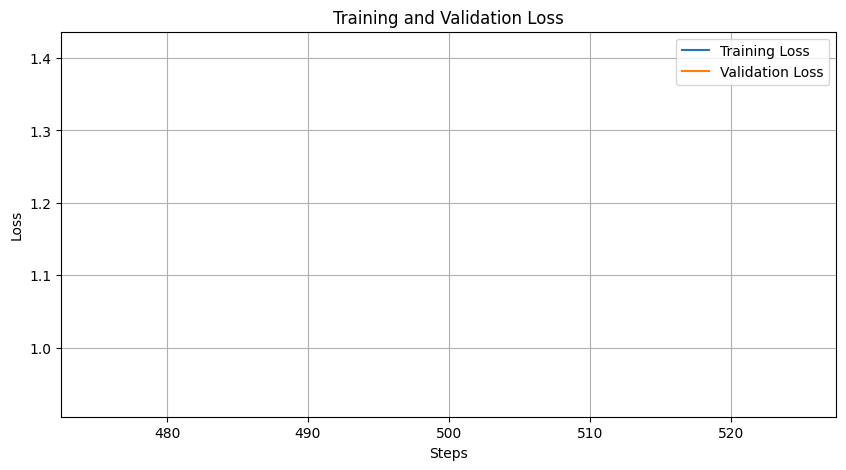

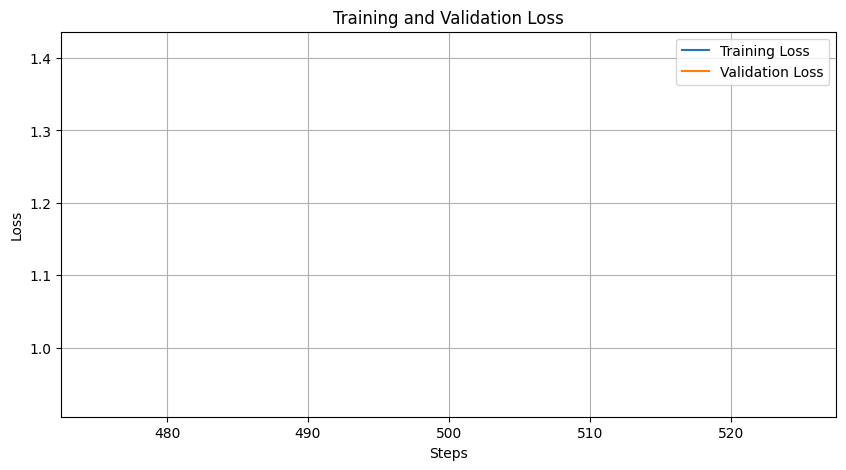

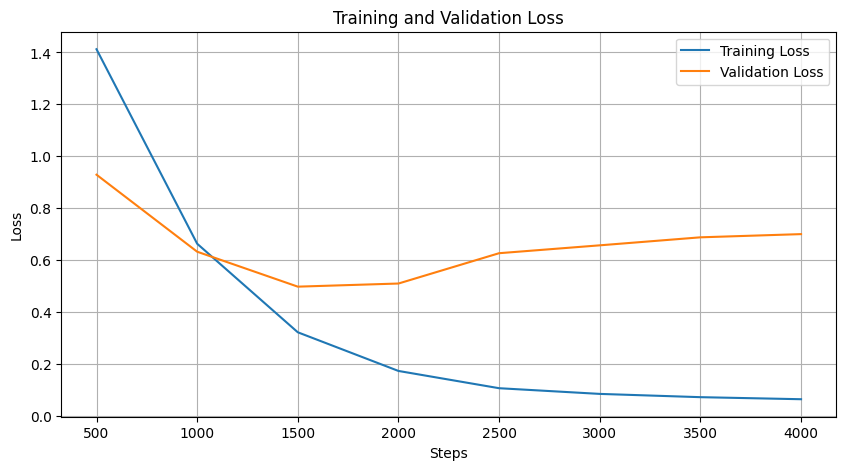

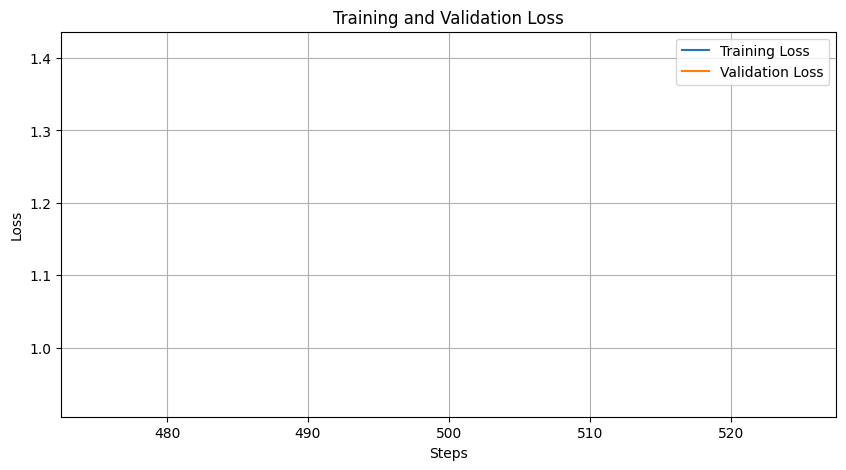

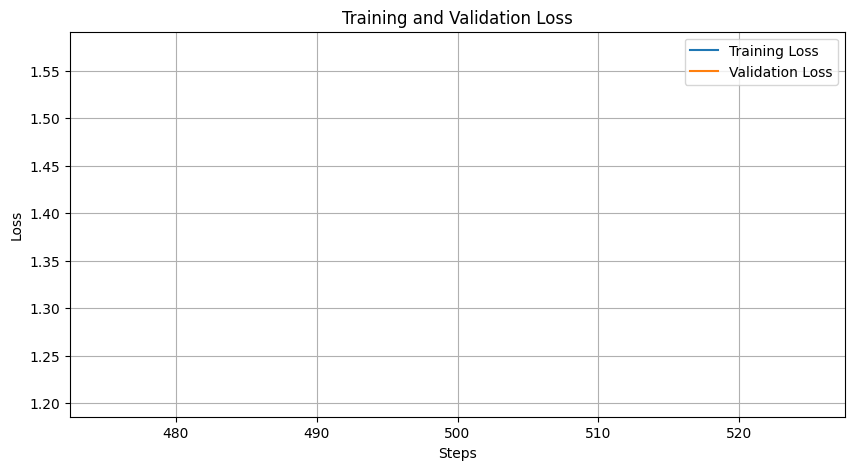

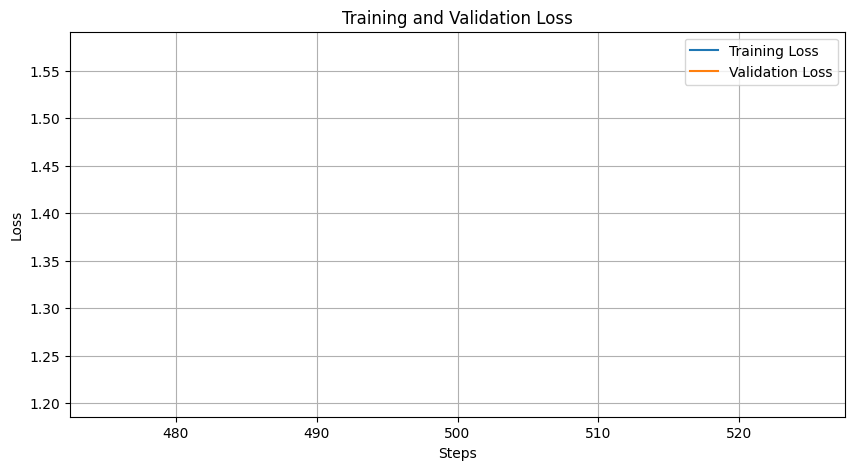

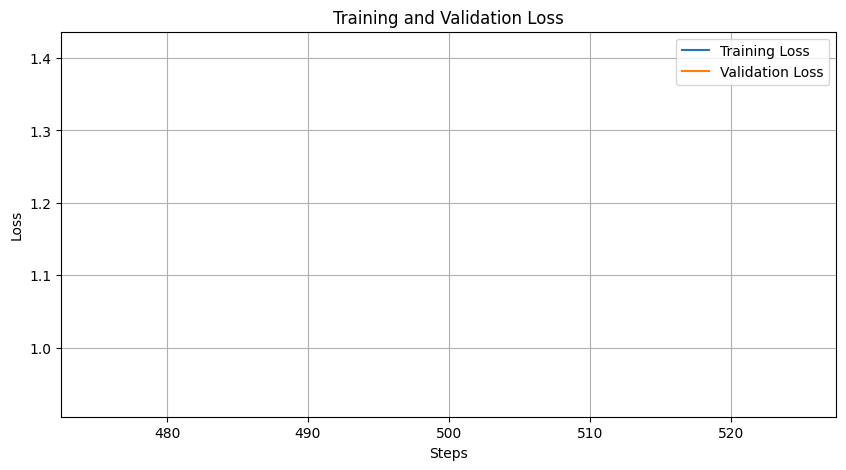

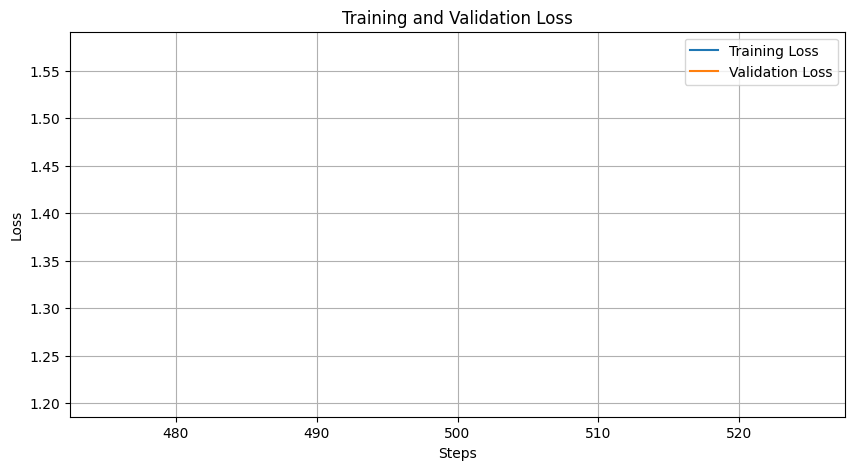

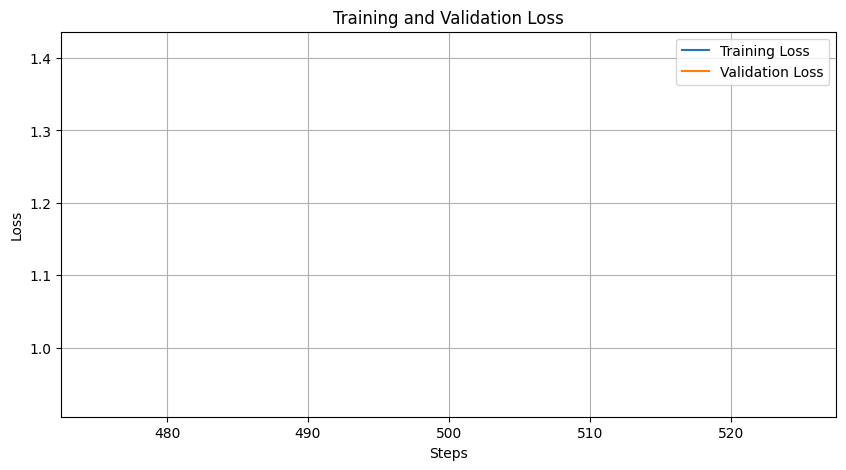

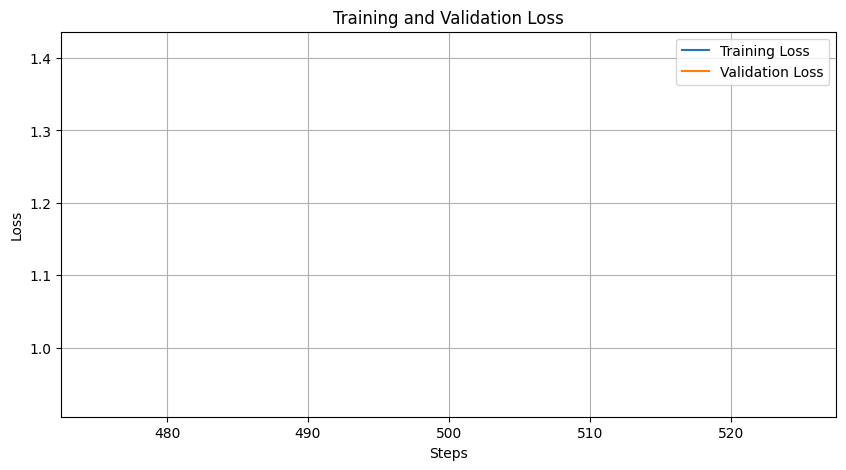

In [132]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

def plot_training_loss(log_dir):
    event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events' in f]
    if not event_files:
        raise ValueError("No event files found in log directory.")

    for event_file in event_files:
        losses = {'Step': [], 'Training Loss': [], 'Validation Loss': []}
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.tag == 'train/loss':
                    losses['Training Loss'].append(v.simple_value)
                    losses['Step'].append(e.step)
                elif v.tag == 'eval/loss':
                    losses['Validation Loss'].append(v.simple_value)

        if losses['Step']:
            df = pd.DataFrame(losses).set_index('Step')
            plt.figure(figsize=(10, 5))
            plt.plot(df['Training Loss'], label='Training Loss')
            plt.plot(df['Validation Loss'], label='Validation Loss')
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# 로그 디렉토리를 지정하여 그래프 그리기
plot_training_loss('./logs')

In [133]:
test_dataset = encoded_dataset['test']

In [134]:
# 평가 데이터셋에 대한 예측 수행
predictions = trainer.predict(test_dataset)

In [135]:
# 예측된 레이블과 실제 레이블 추출
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# 각 클래스별 F1 스코어 계산
class_f1_scores = f1_score(true_labels, predicted_labels, average=None)

# 클래스별 F1 스코어 출력
for class_id, f1_score_value in enumerate(class_f1_scores):
    print(f"Class {class_id} F1 Score: {f1_score_value}")

Class 0 F1 Score: 0.2953995157384988
Class 1 F1 Score: 0.34140127388535035
Class 2 F1 Score: 0.9329940627650553
Class 3 F1 Score: 0.49831649831649827
Class 4 F1 Score: 0.5168408826945413
Class 5 F1 Score: 0.6435643564356436
Class 6 F1 Score: 0.6038781163434903
Class 7 F1 Score: 0.74375
Class 8 F1 Score: 0.5645063597819503


In [ ]:
trainer.save_model('/content/drive/MyDrive/models/CCIT_codebert_N:N(05-19_Juliet_plus)')

In [136]:
import pandas as pd

df2 = pd.read_csv("/content/drive/MyDrive/data/MSR+julite+Div_final_test(2500cut).csv")

In [137]:
df2.head(50)

,CWE ID,vul,lang,code,labels
0,CWE-119,1,c,"enum void func( const char *name, struct group...",0
1,CWE-119,1,c,"void func(struct sshbuf *m, struct ssh *ssh, i...",0
2,CWE-119,1,c,"void func(Jbig2HuffmanState *hs, int offset) {...",0
3,CWE-119,1,c,"void func(struct file *file, unsigned long add...",0
4,CWE-119,1,c,"void func(StyleDifference diff, const RenderSt...",0
5,CWE-119,1,c,long long Chapters::Atom::GetStartTimecode() c...,0
6,CWE-119,1,c,void func(struct atusb *atusb) { struct usb_d...,0
7,CWE-119,1,c,"void func(TGAContext *ctx, GError **err) { TGA...",0
8,CWE-119,1,c,void func( FT_Error error_code ) { FT_Face fa...,0
9,CWE-119,1,c,"void func( const ExtensionIdSet* extensions, i...",0


In [138]:
df2 = df2[['vul', 'code']]

In [139]:
import re

def preprocess2(df2, file_name):
    # 멀티 라인 주석 제거
    df2['code'] = df2['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    # 싱글 라인 주석 제거
    df2['code'] = df2['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    # angle brackets를 사용하는 include 제거
    df2['code'] = df2['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    # 매크로 정의 제거
    df2['code'] = df2['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    # 전처리 지시문 제거
    df2['code'] = df2['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#endif'), "", regex=True)
    # 탭과 여러 공백을 하나의 공백으로
    df2['code'] = df2['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    # 여러 줄바꿈을 하나로
    df2['code'] = df2['code'].replace(re.compile(r'\n\s*\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'return*.*?;'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'return;'), "", regex=True)
    # void func 로 변경
    df2['code'] = df2['code'].replace(re.compile(r'\b([a-zA-Z_]\w*)\s+([a-zA-Z_]\w*)\s*\(([^)]*)\)\s*{'), r"void func(\3){", regex=True)
    # 데이터프레임을 CSV 파일로 저장
    df2.to_csv(file_name, index=False)
    return df2  # 수정된 데이터프레임 반환


def tokenized(examples):
  return tokenizer(examples['code'], pad_to_max_length=True, max_length=MAX_LEN,truncation=True, return_token_type_ids=True)

In [140]:
preprocess2(df2,"preprocess2.csv")
dataset = load_dataset("csv",data_files="preprocess2.csv")['train']
encoded_dataset2 = dataset.map(tokenized,remove_columns=['code'],batched=True)
encoded_dataset2=encoded_dataset2.rename_column(original_column_name='vul',new_column_name='labels')

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [141]:
trainer.predict(encoded_dataset2, metric_key_prefix="eval")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PredictionOutput(predictions=array([[-0.0625    ,  0.00428772,  0.7182617 , ...,  0.47045898,
         0.3010254 ,  0.38183594],
       [-0.14404297, -0.00213051, -1.1289062 , ...,  0.13464355,
        -0.8222656 ,  1.8554688 ],
       [ 0.47973633, -0.76660156, -1.3837891 , ..., -1.7207031 ,
         0.23291016,  0.7807617 ],
       ...,
       [ 0.6542969 ,  0.09429932, -1.3242188 , ..., -1.2998047 ,
         1.7255859 , -0.85498047],
       [ 0.65966797, -0.72509766, -1.0703125 , ..., -0.8466797 ,
         0.6948242 , -0.31518555],
       [ 0.8251953 , -0.68652344, -1.5341797 , ..., -1.1689453 ,
        -1.0107422 ,  1.1679688 ]], dtype=float32), label_ids=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 